# 5. Downstream Analyses of Factor Loadings

Here we use the loadings obtained with Tensor-cell2cell for each element in their respective dimensions (contexts, ligand-receptor pairs, sender cells, receiver cells). These loadings represent the importance of each element in a given factor or latent pattern. We can use this information to gain more insights about the biological processes underlying each of the communication patterns.

In [1]:
import cell2cell as c2c

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Directories

In [3]:
output_folder = '../../data/tc2c-outputs/'
c2c.io.directories.create_directory(output_folder)

../../data/tc2c-outputs/ already exists.


## Load Data

**Load the loadings obtained from the tensor factorization**

In [4]:
factors = c2c.io.load_tensor_factors(output_folder + '/Loadings.xlsx')

**Dictionary with the condition of each sample/context**

This was generated when preprocessing the data in the [Notebook to Generate the 4D-Tensor](./03-Generate-Tensor.ipynb).

In [5]:
from collections import defaultdict

element_dict = defaultdict(lambda: 'Unknown')

In [6]:
context_dict = element_dict.copy()

context_dict.update({'HC1' : 'Control',
                     'HC2' : 'Control',
                     'HC3' : 'Control',
                     'M1' : 'Moderate COVID-19',
                     'M2' : 'Moderate COVID-19',
                     'M3' : 'Moderate COVID-19',
                     'S1' : 'Severe COVID-19',
                     'S2' : 'Severe COVID-19',
                     'S3' : 'Severe COVID-19',
                     'S4' : 'Severe COVID-19',
                     'S5' : 'Severe COVID-19',
                     'S6' : 'Severe COVID-19',
                    })

## Downstream Analyses

### Boxplots to statistically compare group of samples/contexts

The statistical test and the multiple test correction can be changed by modifying the parameters

```statistical_test='t-test_ind'```

```pval_correction='benjamini-hochberg'```

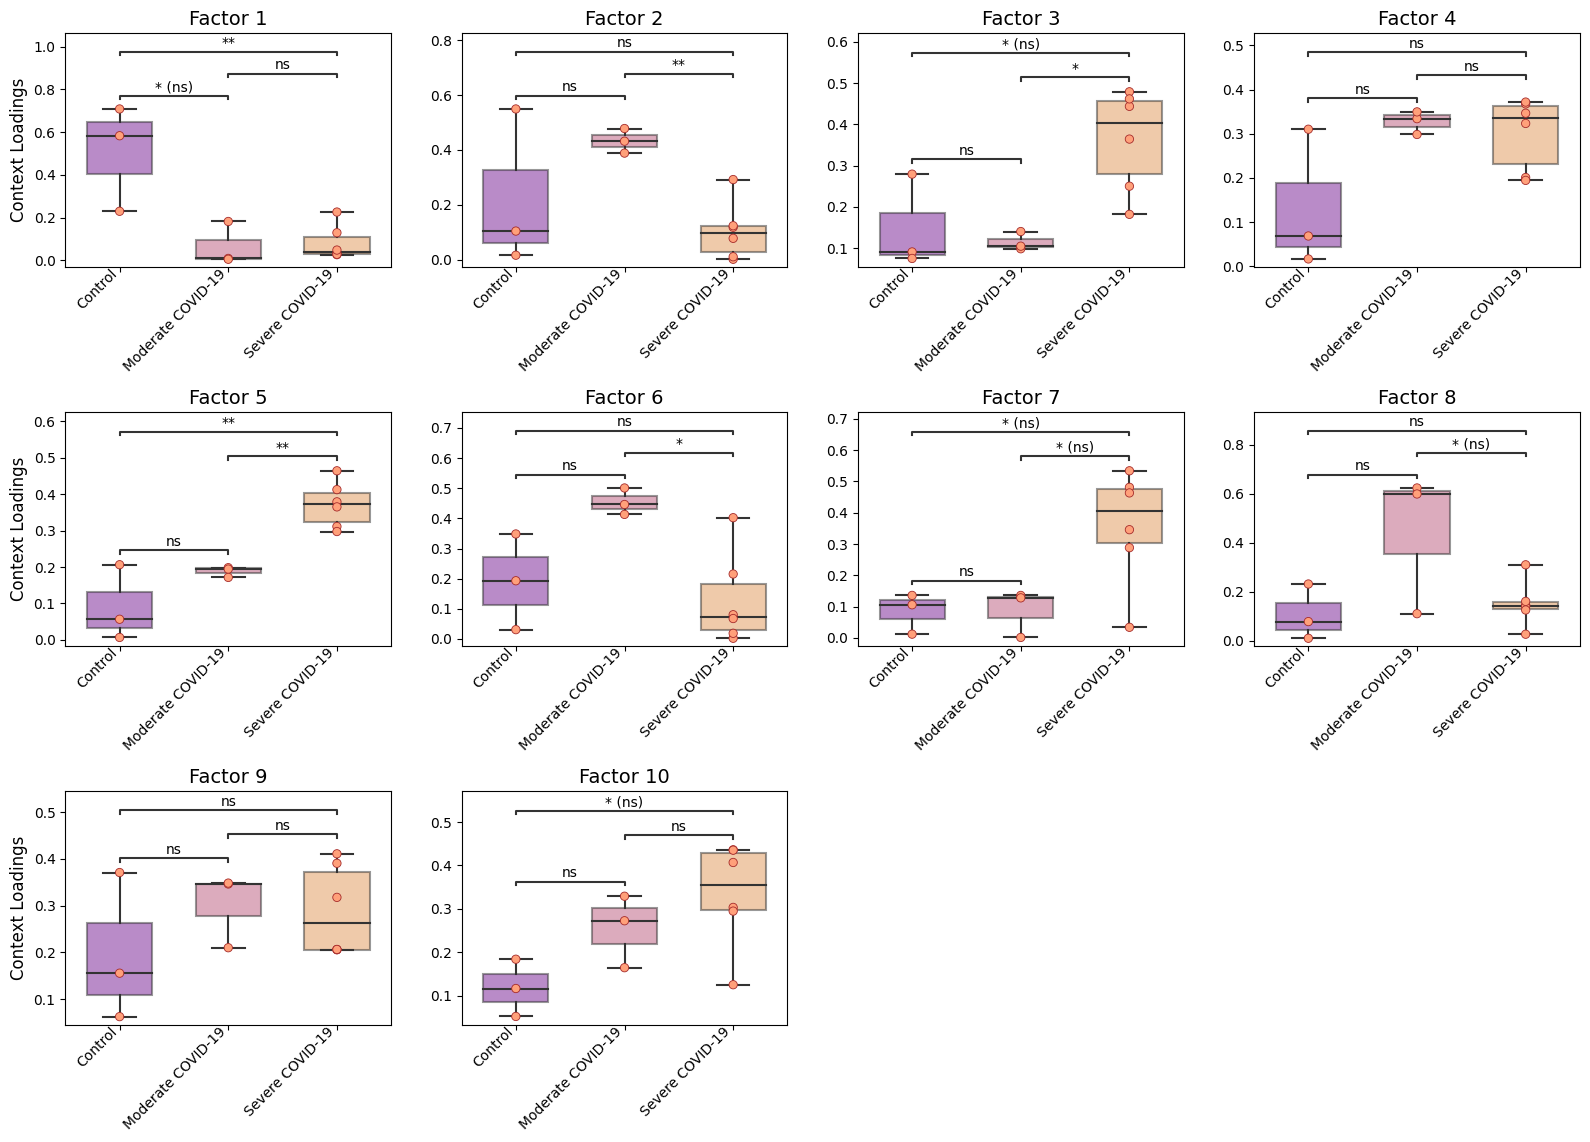

In [7]:
groups_order = ['Control', 'Moderate COVID-19', 'Severe COVID-19']
fig_filename = output_folder + '/BALF-Severity-Boxplots.pdf'

_ = c2c.plotting.context_boxplot(context_loadings=factors['Contexts'],
                                 metadict=context_dict,
                                 nrows=3,
                                 figsize=(16, 12),
                                 group_order=groups_order,
                                 statistical_test='t-test_ind',
                                 pval_correction='fdr_bh',
                                 cmap='plasma',
                                 verbose=False, 
                                 filename=fig_filename
                                )

Here, we see that the communication patterns (or context loadings) identified statistically significant patterns when comparing each pair of COVID-19 severities.

These factors thus represent differences in the ligand-receptor interactions as well as cell types participating in cell-cell communication among the different COVID-19 severities.

### Correlation between Context Loadings & COVID-19 Severity

We first define the ranking of the severity, where higher values represent the worst severity.

In [8]:
def severity_rank(x):
    if x == 'Control':
        ranking = 1
    elif x == 'Moderate COVID-19':
        ranking = 2
    elif x == 'Severe COVID-19':
        ranking = 3
    return ranking

We generate a dataframe with the same indexes as the dataframe containing the loadings, then assign those rankings here.

In [9]:
sev_rank = pd.DataFrame(index=factors['Contexts'].index)
sev_rank['Severity-Ranking'] = [severity_rank(context_dict[idx]) for idx in factors['Contexts'].index]
sev_rank.head()

,Severity-Ranking
HC1,1
HC2,1
HC3,1
M1,2
M2,2


Number of factors from the tensor decomposition

In [10]:
nfactors = factors['Contexts'].shape[1]

**Spearman correlation**

In [11]:
import scipy
for i in range(1, nfactors+1):
    factor = 'Factor {}'.format(i)
    print(factor, scipy.stats.spearmanr(factors['Contexts'][factor],
                                sev_rank['Severity-Ranking']))

Factor 1 SignificanceResult(statistic=-0.47795211939924326, pvalue=0.11604597293054225)
Factor 2 SignificanceResult(statistic=-0.3869136204660541, pvalue=0.21405134607765433)
Factor 3 SignificanceResult(statistic=0.7396878038321621, pvalue=0.005962089821850848)
Factor 4 SignificanceResult(statistic=0.47795211939924326, pvalue=0.11604597293054225)
Factor 5 SignificanceResult(statistic=0.8534859274986488, pvalue=0.0004135604992741732)
Factor 6 SignificanceResult(statistic=-0.31863474626616217, pvalue=0.3127697121445725)
Factor 7 SignificanceResult(statistic=0.6258896801656757, pvalue=0.02947559079163286)
Factor 8 SignificanceResult(statistic=0.11379812366648649, pvalue=0.7247294545217076)
Factor 9 SignificanceResult(statistic=0.2503558720662703, pvalue=0.4325597712381267)
Factor 10 SignificanceResult(statistic=0.6714089296322702, pvalue=0.01681347928292643)


### Heatmaps

**Cluster samples/contexts by their importance across factors**

Here we provide a example on clustering samples (colored by COVID-19 severity). If you plan adding colors for additional data and patient's properties. A detailed guide can be found here: https://www.chrisremmel.com/post/seaborn-color-labels/

Once you have a dataframe or a dictionary for coloring patients/samples, the parameter ```col_colors``` should be changed. Make sure to use the same sample labels as in ```factors['Contexts'].index```

In [12]:
# Generate color by COVID-19 severity for each sample
condition_colors = c2c.plotting.aesthetics.get_colors_from_labels(['Control', 'Moderate COVID-19', 'Severe COVID-19'],
                                                                  cmap='plasma')

# Map these colors to each sample name
color_dict = {k : condition_colors[v] for k, v in context_dict.items()}

# Generate a dataframe used as input for the clustermap
col_colors = pd.Series(color_dict)
col_colors = col_colors.to_frame()
col_colors.columns = ['COVID-19 Severity']

How the color dataframe looks like. If you want to show multiple properties, add new columns with the names you want to display them, and the respective colors.

In [13]:
col_colors.head()

,COVID-19 Severity
HC1,"(0.050383, 0.029803, 0.527975, 1.0)"
HC2,"(0.050383, 0.029803, 0.527975, 1.0)"
HC3,"(0.050383, 0.029803, 0.527975, 1.0)"
M1,"(0.610667, 0.090204, 0.619951, 1.0)"
M2,"(0.610667, 0.090204, 0.619951, 1.0)"


Now generate the clustermap of samples given their respective loadings, colored by category of COVID-19 condition.

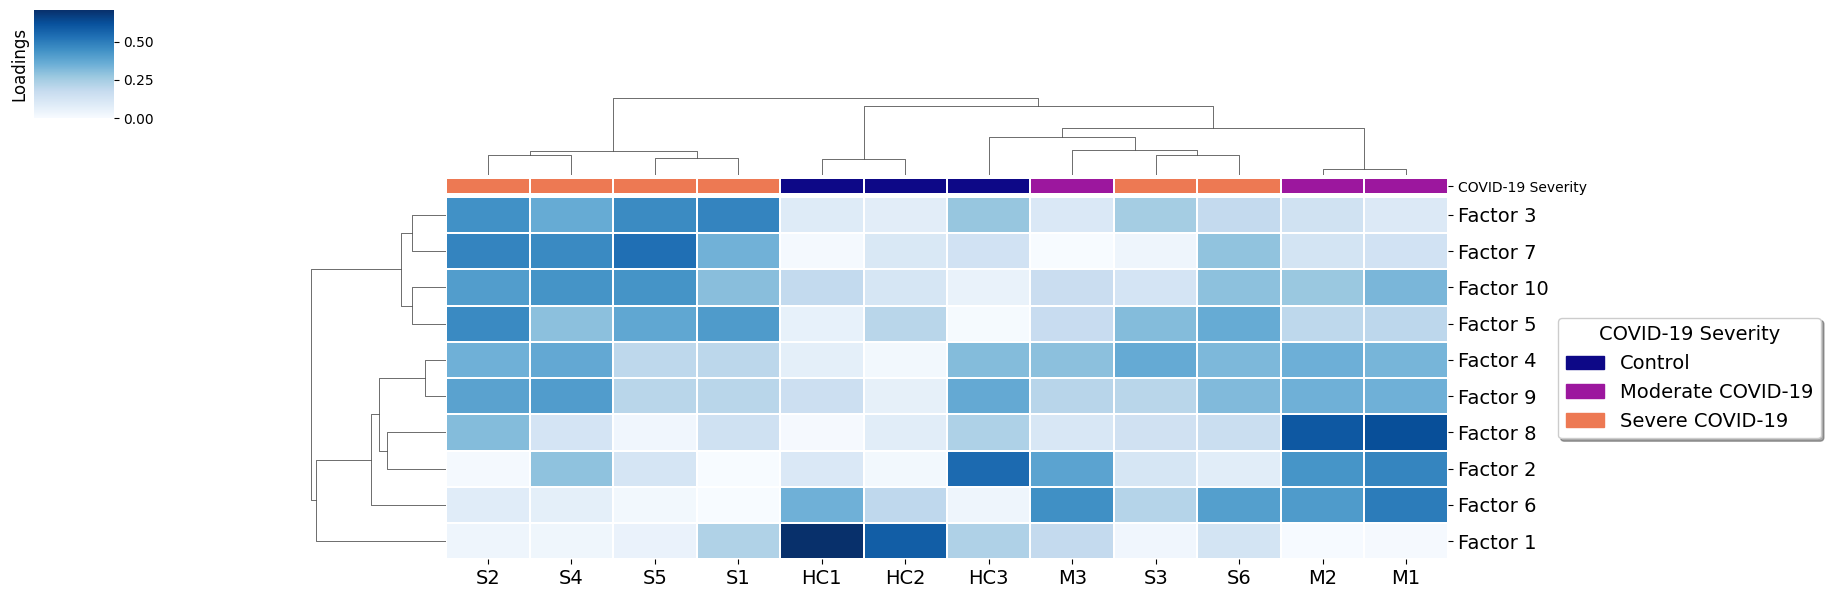

In [14]:
sample_cm = c2c.plotting.loading_clustermap(factors['Contexts'],
                                            use_zscore=False, # Whether standardizing the loadings across factors
                                            col_colors=col_colors, # Change this to color by other properties
                                            figsize=(16, 6),
                                            dendrogram_ratio=0.3,
                                            cbar_fontsize=12,
                                            tick_fontsize=14,
                                            filename=output_folder + 'Clustermap-Contexts.pdf'
                                           )

#Insert legend
plt.sca(sample_cm.ax_heatmap)
legend = c2c.plotting.aesthetics.generate_legend(color_dict=condition_colors,
                                                 bbox_to_anchor=(1.1, 0.5), # Position of the legend (X, Y)
                                                 title='COVID-19 Severity'
                                                )

Here patients are grouped by the importance that each communication pattern (factor) has in relation to the other patients. This captures combinations of related communication patterns that explain similarities and differences at a sample-specific resolution. In this case the differences are reflected with a clear clustering by COVID-19 severity, with some interferance of a few severe samples more similar to moderate cases.

**Cluster LR pairs by their importance across factors**

To consider important LR pairs in at least one factor, set a loading_threshold. This value can be adjusted to be more stringent control the number of ligand-receptor pairs. Here we use ```loading_threshold=0.1``` to prioritize the interactions with high loadings. If we use `loading_threshold=0`, we would return all of pairs.

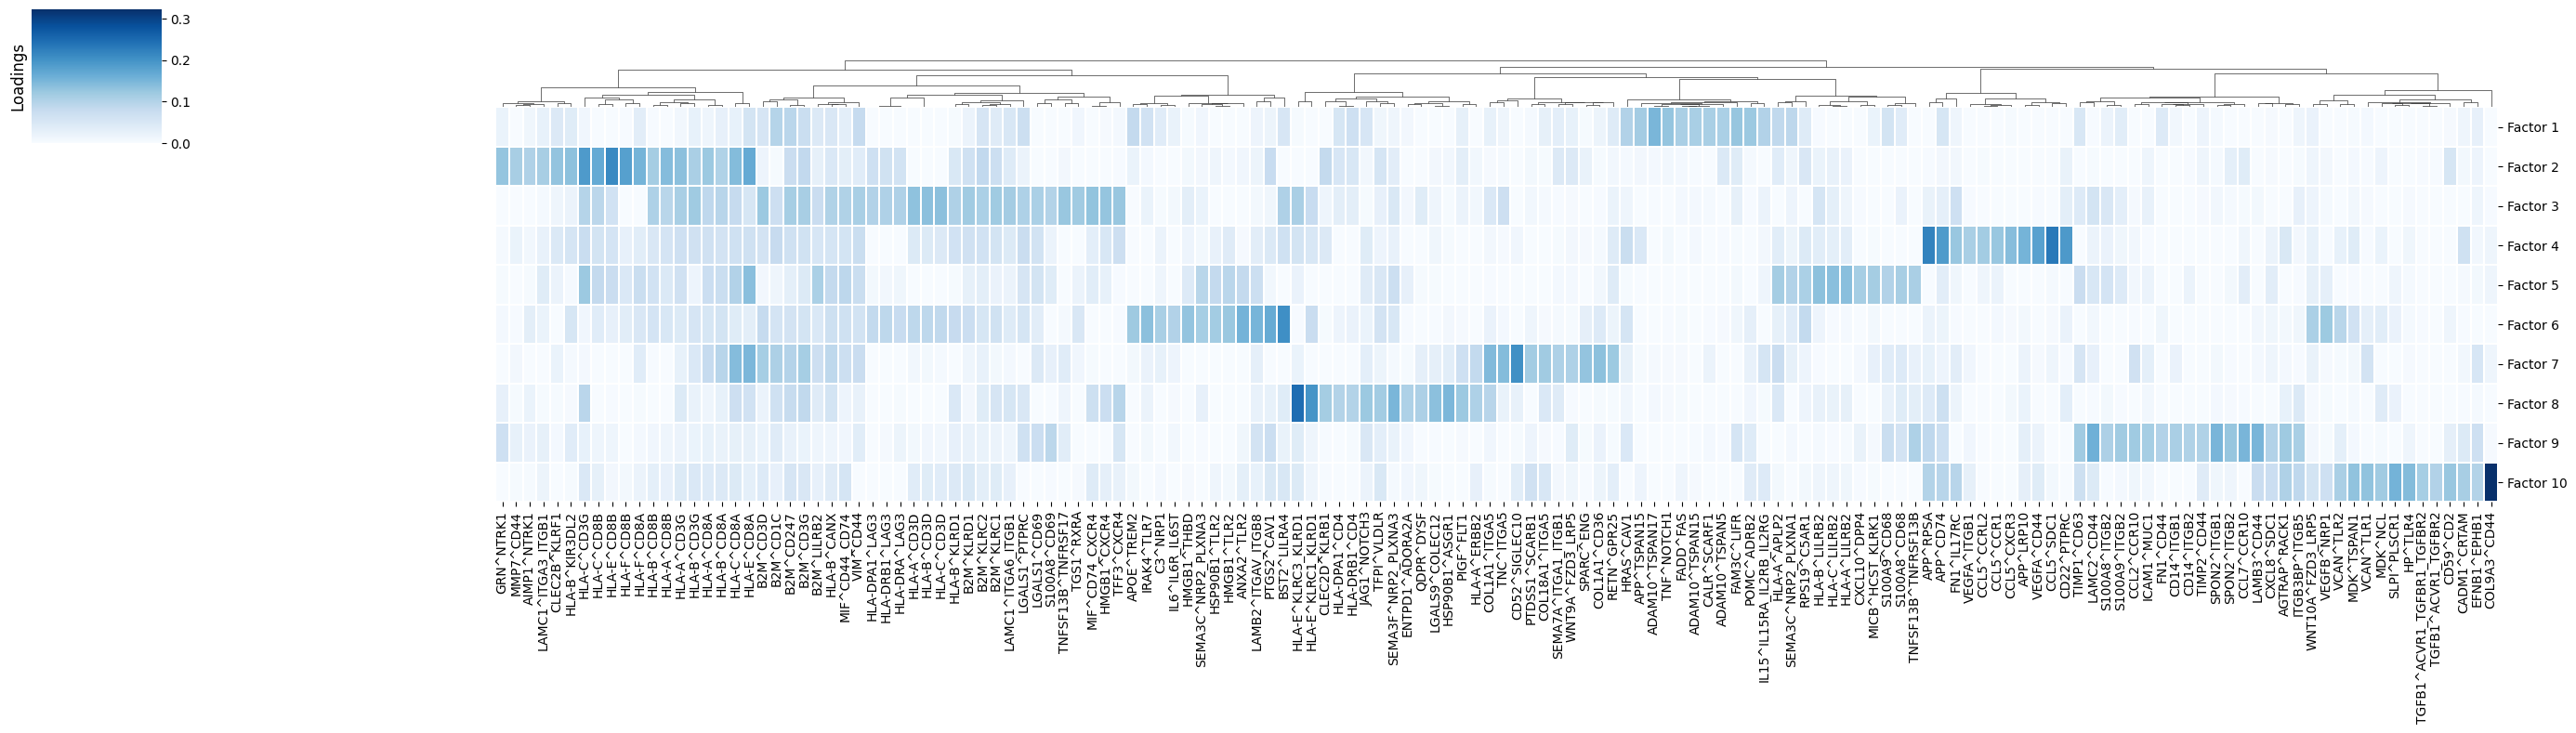

In [15]:
lr_cm = c2c.plotting.loading_clustermap(factors['Ligand-Receptor Pairs'],
                                        loading_threshold=0.1, # To consider only top LRs
                                        use_zscore=False, # Whether standardizing the loadings across factors
                                        figsize=(28, 8),
                                        filename=output_folder + 'Clustermap-LRs.pdf',
                                        row_cluster=False # To avoid clustering of factors
                                       )

In this case, LR pairs are grouped according to how important they for one factor versus the others. This can give an idea of the molecular mechanisms that are crucial in each communication pattern.

**Cluster sender-receiver pairs for an specific factor**

Factor 3 is associated with severe COVID-19 cases (see boxplots). Thus, it would be interesting to determine the cellular interactions underlying this communication pattern. To do so, we define its Loading Product between senders and receiver cells (outer product of loadings for that factor), which represents the joint importance of the cell-cell pair:

In [16]:
selected_factor = 'Factor 3'

In [17]:
loading_product = c2c.analysis.tensor_downstream.get_joint_loadings(factors,
                                                                    dim1='Sender Cells',
                                                                    dim2='Receiver Cells',
                                                                    factor=selected_factor,
                                                                   )

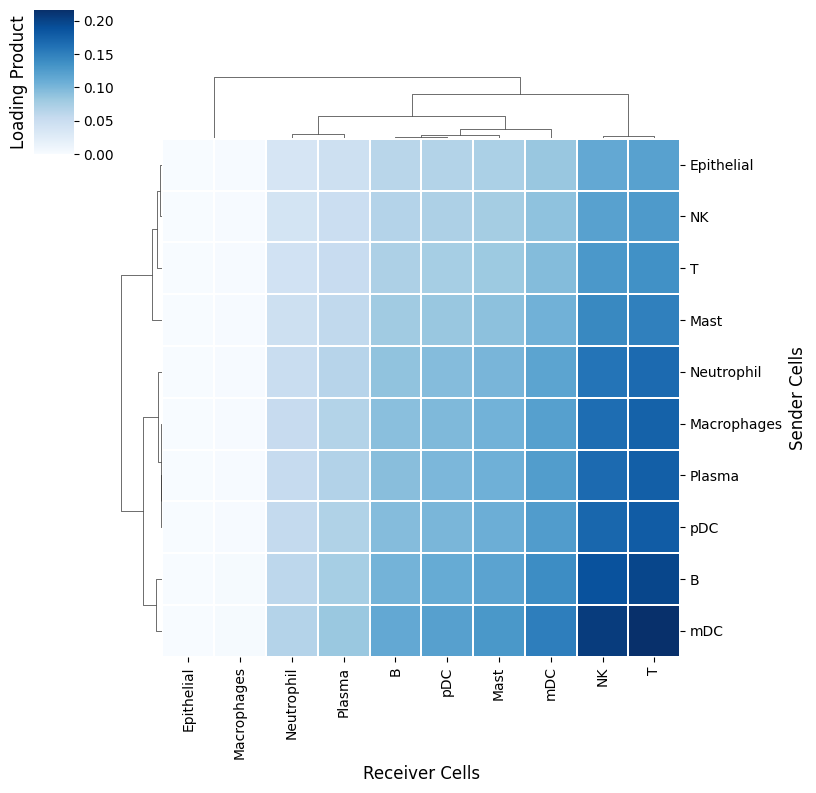

In [18]:
lprod_cm = c2c.plotting.loading_clustermap(loading_product.T, # Remove .T to transpose the axes
                                           use_zscore=False, # Whether standardizing the loadings across factors
                                           figsize=(8, 8),
                                           filename=output_folder + 'Clustermap-CC-Pairs.pdf',
                                           cbar_label='Loading Product',
                                          )

**Evaluation of sender-receiver pair and LR pairs used in a specific factor**

Similarly, we can check what LR pairs each cell-cell pair is using

In [19]:
lr_cell_product = c2c.analysis.tensor_downstream.get_lr_by_cell_pairs(factors,
                                                                      lr_label='Ligand-Receptor Pairs',
                                                                      sender_label='Sender Cells',
                                                                      receiver_label='Receiver Cells',
                                                                      order_cells_by='receivers',
                                                                      factor=selected_factor,
                                                                      cci_threshold=None, # None for considering all cell-cell pairs.
                                                                      lr_threshold=0.075 # Prioritize important pairs. None for considering all of them
                                                                     )

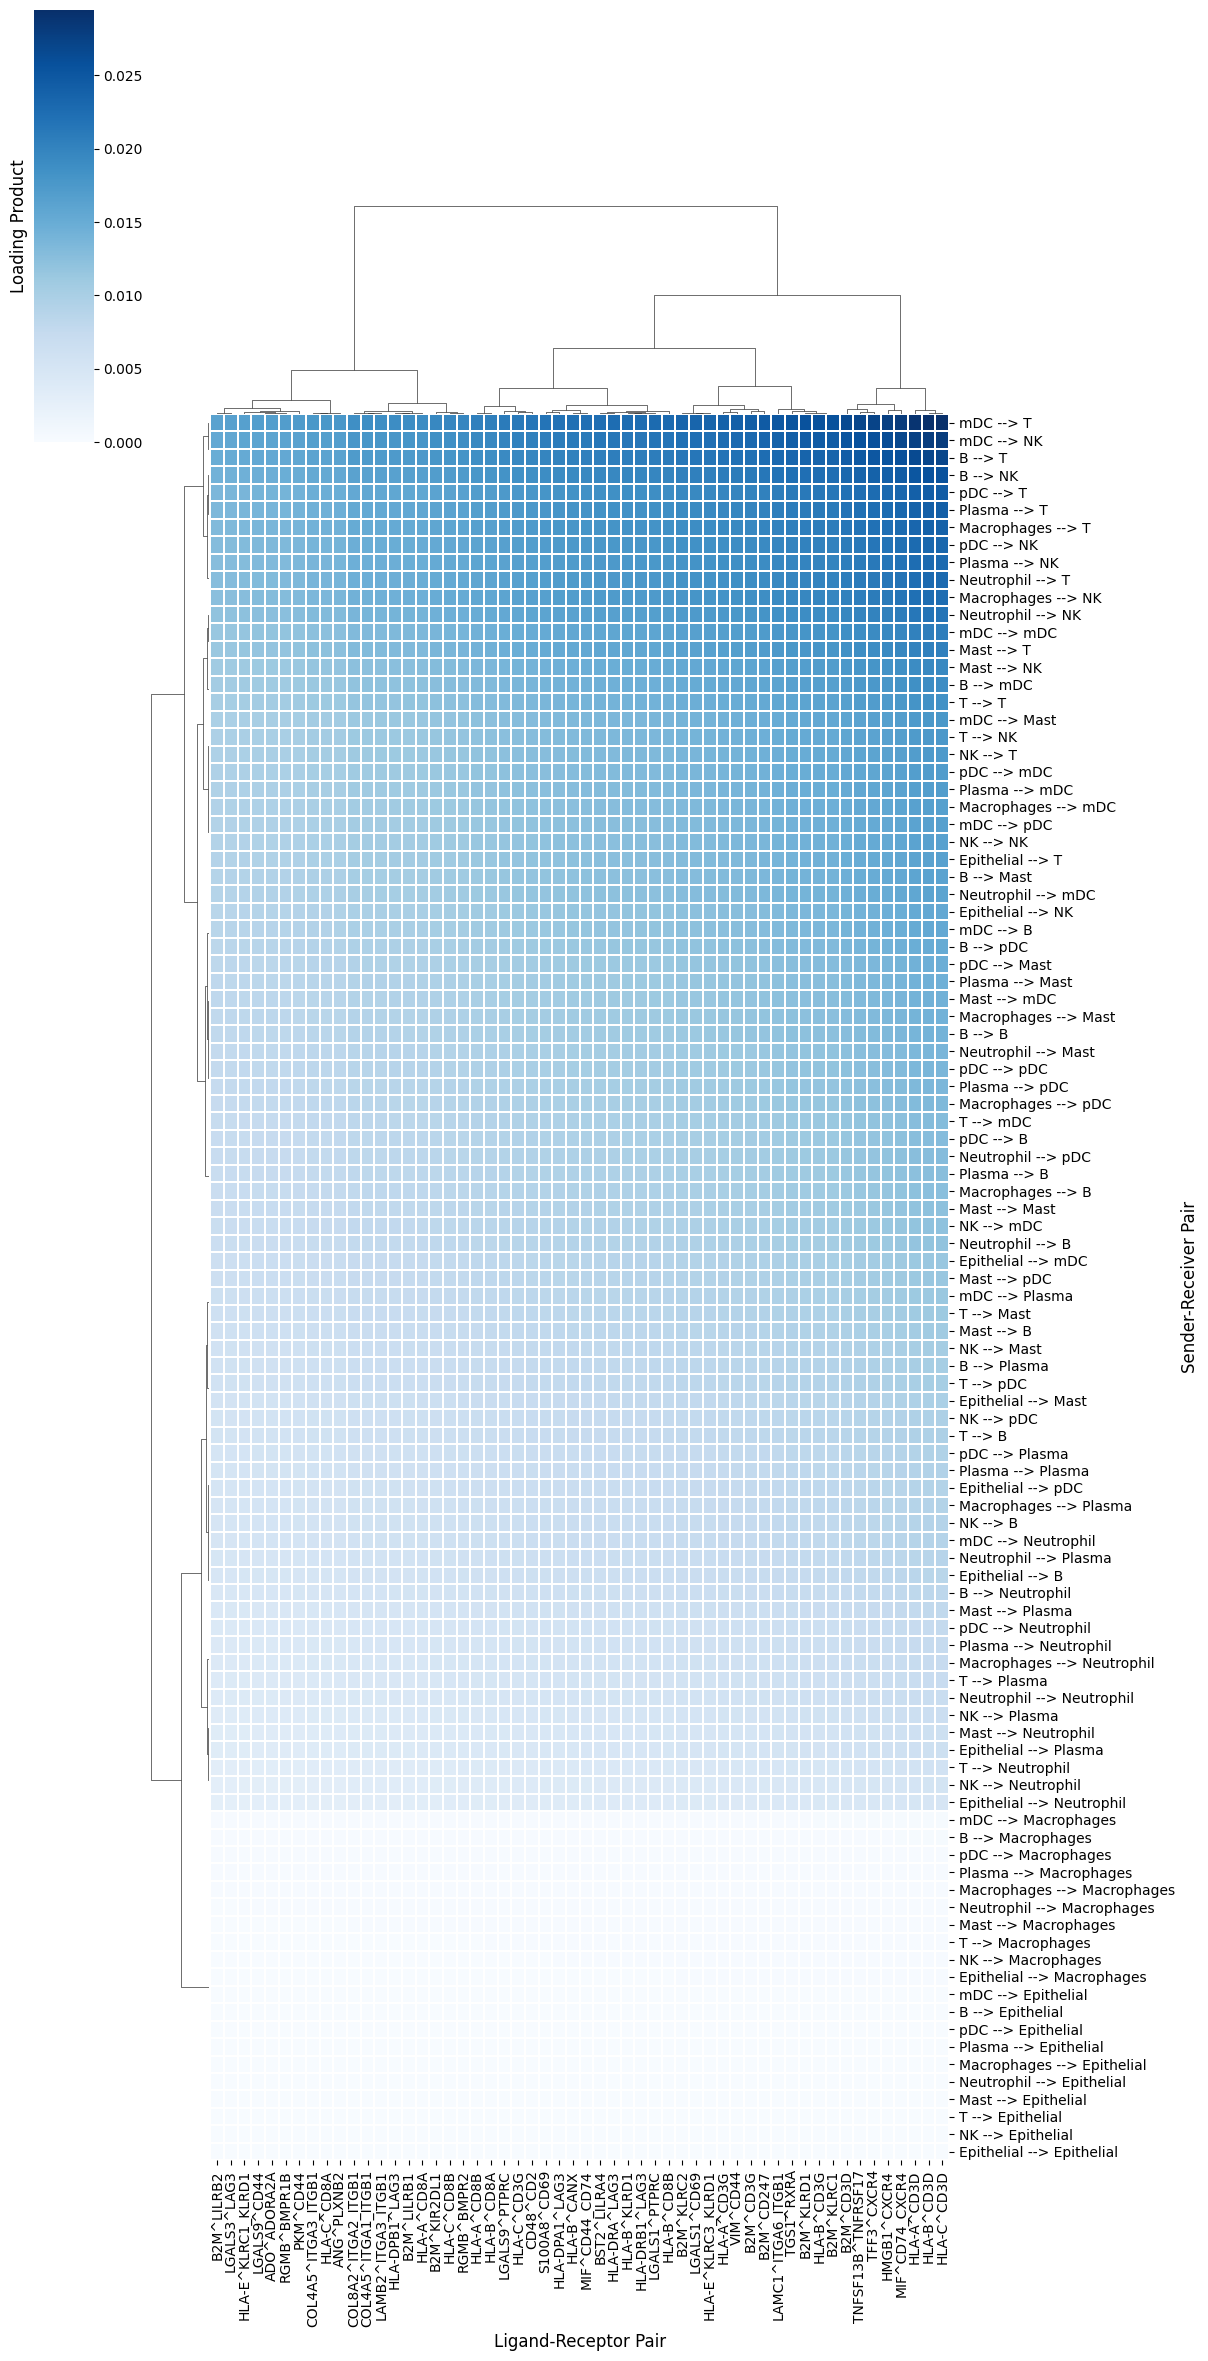

In [20]:
lsr_prod_cm = c2c.plotting.loading_clustermap(lr_cell_product,
                                              use_zscore=False, # Whether standardizing the loadings across factors
                                              figsize=(12, 24),
                                              filename=output_folder + 'Clustermap-LR-CC-Pairs.pdf',
                                              cbar_label='Loading Product',
                                              yticklabels=1
                                             )

### Overall CCI potential: Network visualization of sender-receiver cell pairs

An interaction network can be created for each factor by using the loading product between sender and receiver cells. First we need to choose a threshold to indicate what pair of cells are interacting. To do so, we need to get all the outer products between the loadings for the sender and receiver cells dimensions across all factors.

In [21]:
# Get all outer products as adjacency matrices, one per factor
networks = c2c.analysis.tensor_downstream.get_factor_specific_ccc_networks(factors,
                                                                           sender_label='Sender Cells',
                                                                           receiver_label='Receiver Cells',
                                                                           )

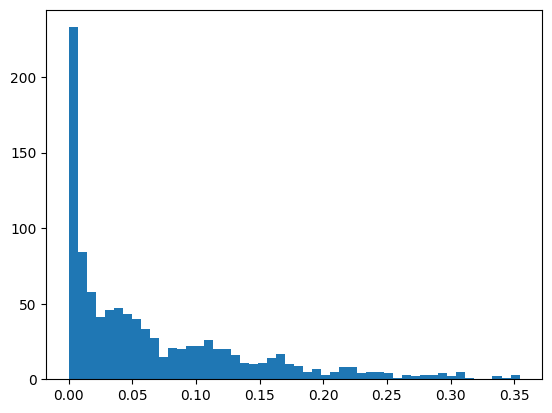

In [22]:
# Then, flatten the adjacency matrices
network_by_factors = c2c.analysis.tensor_downstream.flatten_factor_ccc_networks(networks, orderby='receivers')

# And we can plot the distributions of the weights for each factor-specific network
_ = plt.hist(network_by_factors.values.flatten(), bins = 50)

With this distribution we can set a reasonable threshold. We can also apply some mathematical methods to select one, as for example choosing a percentile. Here we set a threshold of 0.075.

In [23]:
threshold = 0.075

Then, we can plot all networks we are interested in:

(<Figure size 4800x1600 with 3 Axes>,
 array([<Axes: title={'center': 'Factor 3'}>,
        <Axes: title={'center': 'Factor 5'}>,
        <Axes: title={'center': 'Factor 10'}>], dtype=object))

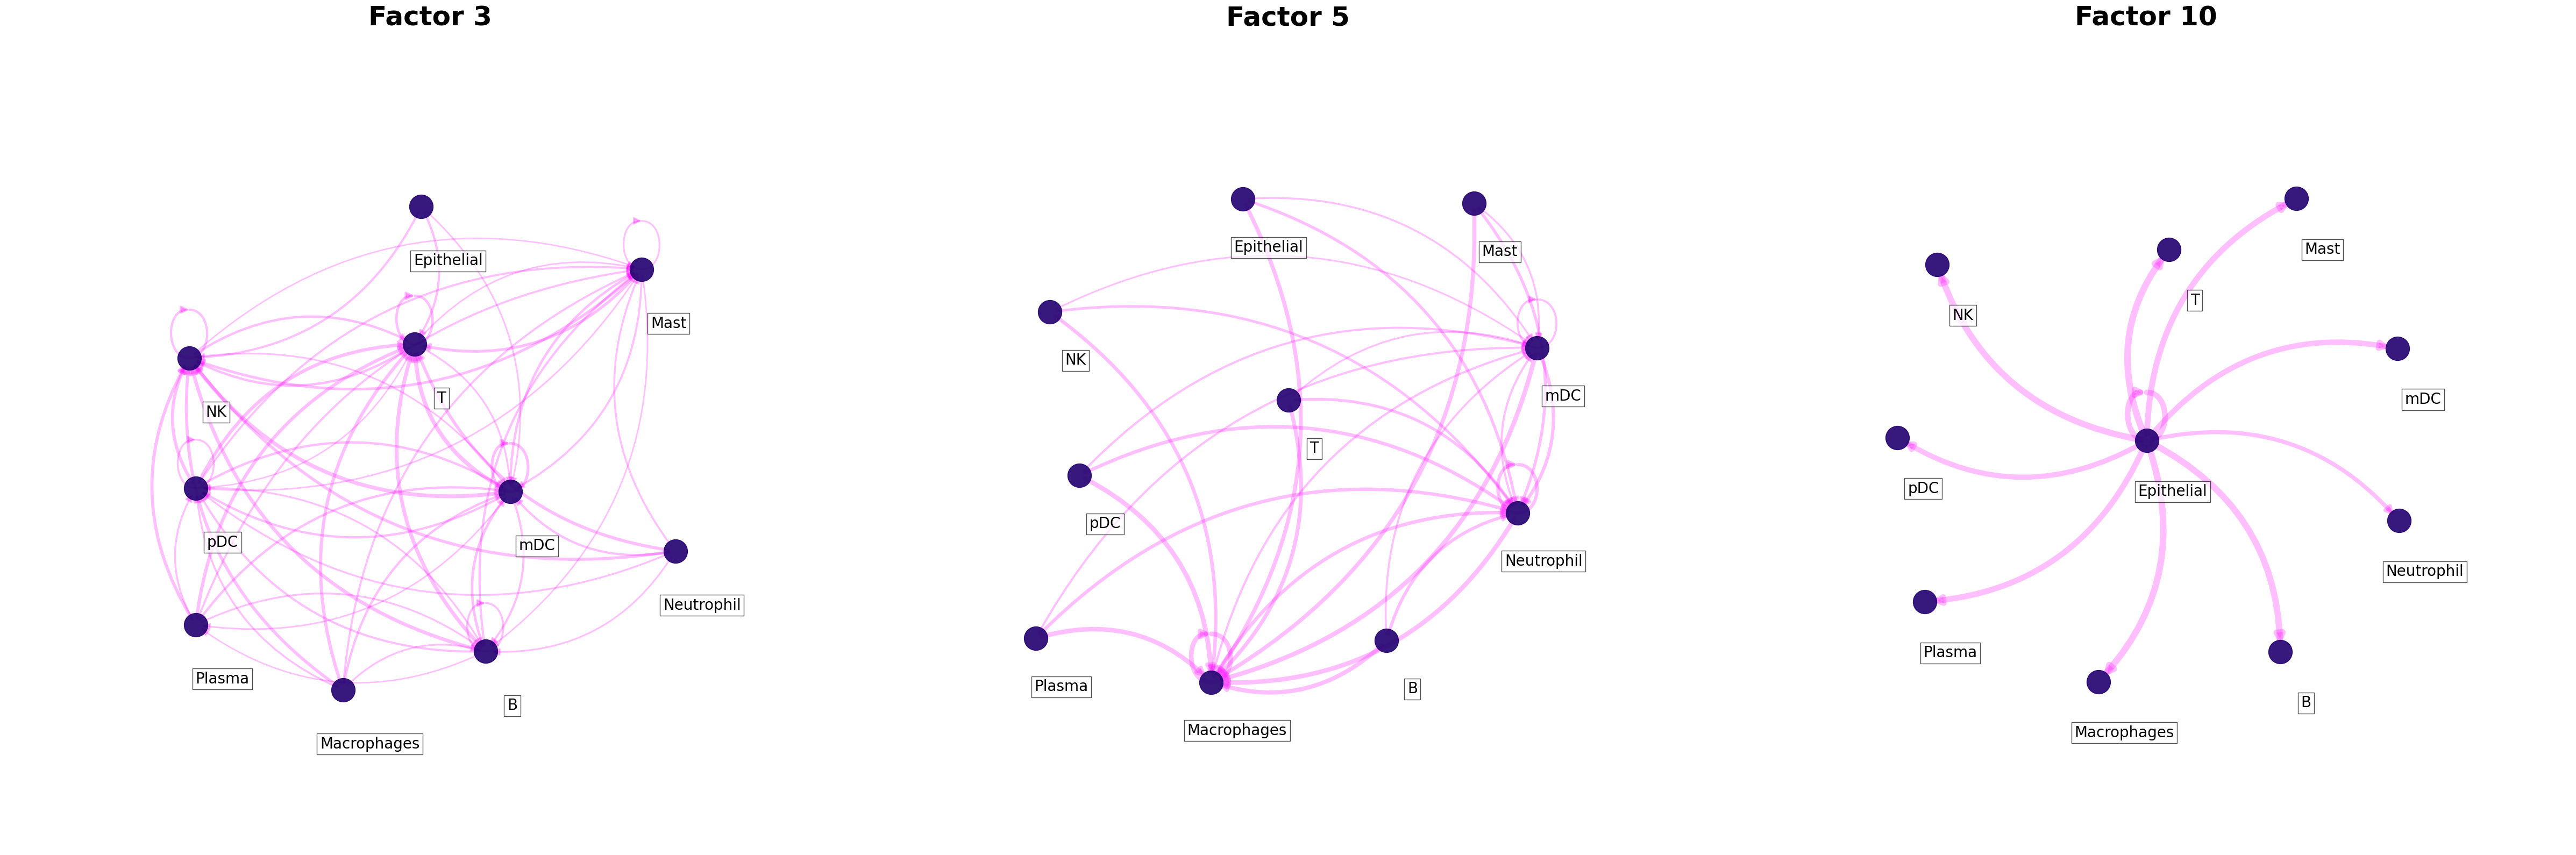

In [24]:
c2c.plotting.ccc_networks_plot(factors,
                               included_factors=['Factor 3', 'Factor 5', 'Factor 10'],
                               ccc_threshold=threshold, # Only important communication
                               nrows=1,
                               panel_size=(16, 16), # This changes the size of each figure panel.
                               filename=output_folder + 'Factor-Networks.pdf',
                              )

### Gini coefficients of the factor-specific cell-cell communication

The Gini coefficient quantifies the extent to which sender-receiver cell pairs differ within a factor according to their importance as measured by their loadings. Here it is use to measure the imbalance of communication for a given factor. In other words, it identifies whether a few cells are key for an identified pattern (low Gini coefficient) or whether the pattern corresponds to a general process that involves most of the cell types (high Gini coefficient). Gini coefficients range between [0, 1]

In [25]:
c2c.analysis.tensor_downstream.compute_gini_coefficients(factors,
                                                         sender_label='Sender Cells',
                                                         receiver_label='Receiver Cells'
                                                        ).sort_values('Gini')

,Factor,Gini
0,Factor 1,0.333537
3,Factor 3,0.383925
8,Factor 8,0.511984
5,Factor 5,0.536594
2,Factor 2,0.537684
6,Factor 6,0.561459
4,Factor 4,0.574522
9,Factor 9,0.680455
7,Factor 7,0.696134
1,Factor 10,0.747488


We observe that the lowest Gini coefficient was obtained by factor 1, which seems to have more balanced cell loadings. Senders and/or receivers are more similar or homogeneous.